# Profile of recovered reads

This notebook profile the recovered reads after spliting, trimming, mapping and filtering.

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind_from_stats, ttest_ind
info = pd.read_excel("../../1_FLAIRseq/data/FLAIRseq.xlsx")
runs = ["20220719_K562R1", "20220719_K562R2", "20220719_K562R3", "20220719_K562R4", "20220729_K562R1", "20220729_K562R2"]

In [2]:
rows = []
for run in runs:
    tmp = info[info["Run"] == run]
    
    path = "../../1_FLAIRseq/results/demux/splitted/%s/stats.tsv" % run
    d = pd.read_csv(path, sep="\t", index_col=0)
    total = d["Total"].values[0]
    assigned = d["Assigned"].values[0]

    trimmed = 0
    for cell in tmp["Cell"]:
        path = "../../1_FLAIRseq/results/demux/trimmed/%s/%s.log" % (run, cell)
        with open(path) as f:
            for line in f:
                if line.startswith("Pass"):
                    trimmed += int(line.split()[1])

    mapped = 0
    for cell in tmp["Cell"]:
        path = "../../1_FLAIRseq/results/mapping/minimap2/%s/%s.flagstat" % (run, cell)
        with open(path) as f:
            for line in f:
                if "primary mapped" in line:
                    mapped += int(line.split()[0])

    filtered = 0
    for cell in tmp["Cell"]:
        path = "../../1_FLAIRseq/results/mapping/stat_clip/%s/%s.log" % (run, cell)
        filtered += int(open(path).readlines()[-1].split()[0])

    row = [run, total, assigned, trimmed, mapped, filtered]
    rows.append(row)

dat = pd.DataFrame(rows)
dat.columns = ["Run", "TotalReads", "AssignedReads", "TrimmedReads", "MappedReads", "FilteredReads"]
for c in dat.columns[1:]:
    dat["%s[%%]" % c] = dat[c] * 100 / dat["TotalReads"]

TotalReads[%]       100.000000
AssignedReads[%]     68.028429
TrimmedReads[%]      47.655145
MappedReads[%]       47.304074
FilteredReads[%]     39.297232
dtype: float64
TotalReads[%]       0.000000
AssignedReads[%]    5.627822
TrimmedReads[%]     5.731915
MappedReads[%]      5.712007
FilteredReads[%]    4.754620
dtype: float64


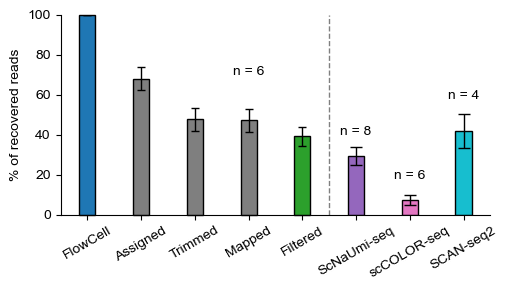

In [3]:
d = dat[dat.columns[-5:]]
ys = d.mean(axis=0)
yerr = d.std(axis=0)
print(ys)
print(yerr)
xs = np.arange(len(ys))
colors = ["C0", "C7", "C7", "C7", "C2"]
ticks = ["FlowCell", "Assigned", "Trimmed", "Mapped", "Filtered", 
         "ScNaUmi-seq", "scCOLOR-seq", "SCAN-seq2"]
w = 0.3

# ScNaUMI-seq: N = 8
# scCOLOR-seq: N = 6
# sci-fate: 二代的方法
# SCAN-seq: 下载到的是拆分好的数据，无法计算产率
# SCAN-seq2: N = 4

plt.figure(figsize=(5.2, 3))
plt.bar(xs, ys, yerr=yerr, edgecolor="black", width=w, lw=1, color=colors, clip_on=False, 
        error_kw={"lw": 1, "capsize": 3})

plt.bar([5, 6, 7], [29.4576, 7.345930, 42.048725], yerr=[4.598, 2.644300, 8.449762], color=["C4", "C6", "C9"], 
        width=w, lw=1, edgecolor="black", error_kw={"lw": 1, "capsize": 4})
plt.text(5, 40, "n = 8", ha="center")
plt.text(6, 18, "n = 6", ha="center")
plt.text(7, 58, "n = 4", ha="center")
plt.text(3, 70, "n = %d" % len(d), ha="center")

# plt.text(1, 90, "scNanoNascentRNA-seq", ha="left")
# plt.text(4.8, 90, "Other technologies", ha="left")

plt.axvline(4.5, lw=1, ls="--", color="grey")
plt.ylabel("% of recovered reads")
plt.xticks(np.arange(len(ticks)), ticks, rotation=30)
plt.xlim(-0.5, 7.5)
plt.ylim(0, 100)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/filter_proportion.pdf")

In [4]:
ratios = d["FilteredReads[%]"].values
print("FLAIR-seq vs. ScNaUmi-seq:")
print(ttest_ind_from_stats(np.mean(ratios), np.std(ratios), len(ratios), 29.4576, 4.598, 8))
print("FLAIR-seq vs. scCOLOR-seq:")
print(ttest_ind_from_stats(np.mean(ratios), np.std(ratios), len(ratios), 7.345930, 2.644300, 6))
print("FLAIR-seq vs. SCAN-seq2:")
print(ttest_ind_from_stats(np.mean(ratios), np.std(ratios), len(ratios), 42.048725, 8.449762, 4))

FLAIR-seq vs. ScNaUmi-seq:
Ttest_indResult(statistic=4.055578194558875, pvalue=0.0015942974735738314)
FLAIR-seq vs. scCOLOR-seq:
Ttest_indResult(statistic=15.399036601182662, pvalue=2.715967587468202e-08)
FLAIR-seq vs. SCAN-seq2:
Ttest_indResult(statistic=-0.6865461810738009, pvalue=0.5117735636791099)
